In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Custom_OCR/EnglishFnt.tgz.zip" -d "/content/"

Archive:  /content/drive/MyDrive/Custom_OCR/EnglishFnt.tgz.zip
  inflating: /content/EnglishFnt.tgz  


In [ ]:
!tar -xzvf "/content/EnglishFnt.tgz" -C "/content/"     #[run this cell to extract tar.gz files]

Streaming output truncated to the last 5000 lines.
English/Fnt/Sample043/img043-00095.png
English/Fnt/Sample043/img043-00096.png
English/Fnt/Sample043/img043-00097.png
English/Fnt/Sample043/img043-00098.png
English/Fnt/Sample043/img043-00099.png
English/Fnt/Sample043/img043-00100.png
English/Fnt/Sample043/img043-00101.png
English/Fnt/Sample043/img043-00102.png
English/Fnt/Sample043/img043-00103.png
English/Fnt/Sample043/img043-00104.png
English/Fnt/Sample043/img043-00105.png
English/Fnt/Sample043/img043-00106.png
English/Fnt/Sample043/img043-00108.png
English/Fnt/Sample043/img043-00109.png
English/Fnt/Sample043/img043-00110.png
English/Fnt/Sample043/img043-00111.png
English/Fnt/Sample043/img043-00112.png
English/Fnt/Sample043/img043-00113.png
English/Fnt/Sample043/img043-00114.png
English/Fnt/Sample043/img043-00115.png
English/Fnt/Sample043/img043-00116.png
English/Fnt/Sample043/img043-00117.png
English/Fnt/Sample043/img043-00118.png
English/Fnt/Sample043/img043-00119.png
English/Fnt/S

In [2]:
!pip install keras

In [3]:
!pip install keras-layer-normalization

  Preparing metadata (setup.py) ... done
  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.16.0-py3-none-any.whl size=4654 sha256=a9344bf109ea1b6b8727f620eef20d2fd31098572458c8ddf2a322ed03d32eaf
  Stored in directory: /root/.cache/pip/wheels/ed/3a/4b/21db23c0cc56c4b219616e181f258eb7c57d36cc5d056fae9a
Successfully built keras-layer-normalization


In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 33.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.6 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=9afe77d012c010746190b74bcc4fe579088531b7959e7eaea92771360b9bf43a
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB7, ResNet50V2, ResNet101V2, ResNet152V2, VGG16, VGG19, InceptionResNetV2
import numpy as np
import wandb
from wandb.keras import WandbCallback

path_dataset = '/content/English'
IMG_SIZE = 64
batch_size = 32
NUM_CLASSES = 62

epochs = 3
LR = 1e-5

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_dataset,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_dataset,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size
)

class_names = train_ds.class_names

# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(class_names[int(labels[i])])
#         plt.axis("off")

    #plt.show()



data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        #layers.experimental.preprocessing.RandomFlip("vertical"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomContrast(0.2),
    ]
)
# plt.figure(figsize=(10, 10))
# for images, _ in train_ds.take(1):
#     for i in range(9):
#         augmented_images = data_augmentation(images)
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(augmented_images[0].numpy().astype("uint8"))
#         plt.axis("off")
#     plt.show()


def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

size = (IMG_SIZE, IMG_SIZE)
train_ds = train_ds.map(lambda image, label: (tf.image.resize(image, size), label))
val_ds = val_ds.map(lambda image, label: (tf.image.resize(image, size), label))

train_ds = train_ds.map(input_preprocess)
val_ds = val_ds.map(input_preprocess)

def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

    model = ResNet50V2(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.25
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="ResNet50")
    optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

def unfreeze_model(model):
    for layer in model.layers:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model


wandb.login()

wandb.init(
      # Set entity to specify your username or team name
      # ex: entity="carey",
      # Set the project where this run will be logged
      project="ocr-natural-images",
      # Track hyperparameters and run metadata
      config={
      "learning_rate": LR,
      "architecture": "ResNet50V2",
      "dataset": "Chars74K",
      "hyper": "parameter",})


model = build_model(num_classes=NUM_CLASSES)
model = unfreeze_model(model)
#model = keras.models.load_model('saved/model/model.h5')

model.summary()

hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=1, callbacks=[WandbCallback()])
model.save('/content/')

In [ ]:
!zip -r /content/wandb_model.zip /content/wandb

  adding: content/wandb/ (stored 0%)
  adding: content/wandb/latest-run/ (stored 0%)
  adding: content/wandb/latest-run/logs/ (stored 0%)
  adding: content/wandb/latest-run/logs/debug-internal.log (deflated 94%)
  adding: content/wandb/latest-run/logs/debug.log (deflated 72%)
  adding: content/wandb/latest-run/files/ (stored 0%)
  adding: content/wandb/latest-run/files/wandb-summary.json (deflated 44%)
  adding: content/wandb/latest-run/files/media/ (stored 0%)
  adding: content/wandb/latest-run/files/media/graph/ (stored 0%)
  adding: content/wandb/latest-run/files/media/graph/graph_summary_5e7fe53749b47a12aa4f.graph.json (deflated 92%)
  adding: content/wandb/latest-run/files/output.log (deflated 89%)
  adding: content/wandb/latest-run/files/model-best.h5 (deflated 45%)
  adding: content/wandb/latest-run/files/wandb-metadata.json (deflated 58%)
  adding: content/wandb/latest-run/files/config.yaml (deflated 58%)
  adding: content/wandb/latest-run/files/requirements.txt (deflated 55%)


1/1 [==============================] - 6s 6s/step
predicted as:7


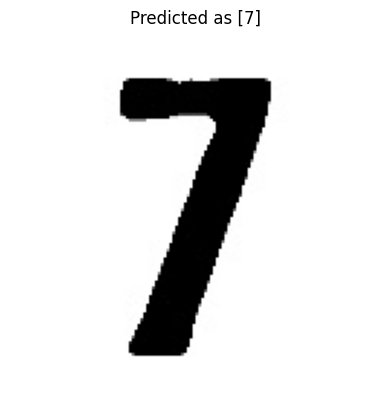

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
import os

# Define the path to the weights file
WEIGHTS_PATH = "/content/drive/MyDrive/Custom_OCR/self_model_best.h5"

DATASET_PATH = '/content/English'
IMG_SIZE = 128
class_names = [f"Sample{i:03d}" for i in range(1, 63)]

class_names = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
    'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
    'U', 'V', 'W', 'X', 'Y', 'Z'
]


def predict(img_path):
    model = tf.keras.models.load_model(WEIGHTS_PATH)

    image = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = np.expand_dims(image, axis=0)

    result = model.predict(image)
    pred = np.argmax(result, axis=-1)[0]

    print(f'predicted as:{class_names[pred]}')

    # Plot the image
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot()
    fig.subplots_adjust(top=0.85)

    plt.imshow(image.squeeze().astype("uint8"))
    plt.title(f'Predicted as [{class_names[pred]}]')

    plt.axis("off")
    plt.show()


if __name__ == "__main__":
    img_path = '/content/drive/MyDrive/Custom_OCR/output_char.jpg'
    predict(img_path)
